Okay I still should check that boltzmann stuff is working properly before doing the Q-values, so try running the boltzmann on the reward matrix rather than the q values and check that it gives you the distribution you'd expect just to make sure I'm not messing anything up there. 

Then if that's all fine, which it probably is, have another look at the Q-value and V-Value calculations in learn, and if they look right then step through and check that it's doing what I expect them to be doing. 

If it's something wrong with one of those then that might fix the learning side of things as well, but at least we'll have a proper trajectory to learn from because atm the one it's creating, and the resulting policy is abysmal, so fix that first, get the expert to perform more expertly and then you can check to see if there are problems with the learning algorithm :) 

Issue has to be in policy iteration somewhere 

In [1]:
%reload_ext autoreload
from env import SingleStateSpace 
from generate_trajectory import generate_trajectory
from policy import Boltzmann 
from learn import compute_q_with_values
from RewardFunctions import SingleStateReward
import numpy as np 
from learn import policy_iteration
from utils import normalise_pi
from policy_walk import policy_walk 
import matplotlib.pyplot as plt 

In [32]:

trajectory_length = 20 
#set up the agent and their policy 
env = SingleStateSpace(n_actions = 10, discount_rate = 0.1, R_max = 5)
#so we have access to env.reward
observation_times = np.cumsum(np.random.uniform(0, 2, size=trajectory_length))
print("Generated observation times:") 
print(observation_times)

# Use meshgrid to create a grid of all possible combinations of s, a, and t
s_grid, a_grid, t_grid = np.meshgrid(env.states, env.actions, observation_times, indexing='ij')
R = np.vectorize(env.reward)(s_grid,a_grid,t_grid)

# Calculate the reward for each combination using vectorized operations - oh I'm not actually using a boltzmann policy here I'm just using a normalised reward vector? 
(optimal_pi, optimal_values) = policy_iteration(env, len(observation_times), R)
optimal_q_values = np.ones((env.n_states, env.n_actions, len(observation_times)))
for s in range(env.n_states):
    for a in range(env.n_actions): 
        for t in range(len(observation_times)):
            optimal_q_values[s,a,t] = compute_q_with_values(env,s,a,t,optimal_values,R) 

b = Boltzmann(optimal_q_values, env.actions, alpha = 0.5)
observations = generate_trajectory(env,b,observation_times)

print("Generated trajectory") 
print(observations)

n_samples = 200 
learned_rewards = [] 
for i in range(n_samples): 
    if (i%10 == 0): 
        print(i)
    learned_rewards.append((policy_walk(env,observations,optimal_q_values)))
#Took 4 minutes to get 100 samples 
# print("Running policy walk") 
# learned_R = policy_walk(env, observations, optimal_q_values) # there's a better way than passing in the Q* values but I cba dealing with it now 
# print("finished learning policy")

Generated observation times:
[ 0.04242368  0.7727845   2.47125374  2.57927479  4.57721269  5.21712659
  7.12476918  7.48839857  9.11989769 10.60369279 12.29069534 14.25001394
 16.11948372 17.15741083 17.84233285 19.45747533 20.5028744  21.41362208
 22.29825815 23.22084721]
Generated trajectory
[[0, 5, 0], [0, 0, 1], [0, 8, 2], [0, 5, 3], [0, 8, 4], [0, 6, 5], [0, 8, 6], [0, 6, 7], [0, 1, 8], [0, 5, 9], [0, 3, 10], [0, 0, 11], [0, 4, 12], [0, 0, 13], [0, 9, 14], [0, 7, 15], [0, 2, 16], [0, 5, 17], [0, 1, 18], [0, 6, 19]]
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


[ 0.04242368  0.7727845   2.47125374  2.57927479  4.57721269  5.21712659
  7.12476918  7.48839857  9.11989769 10.60369279 12.29069534 14.25001394
 16.11948372 17.15741083 17.84233285 19.45747533 20.5028744  21.41362208
 22.29825815 23.22084721]


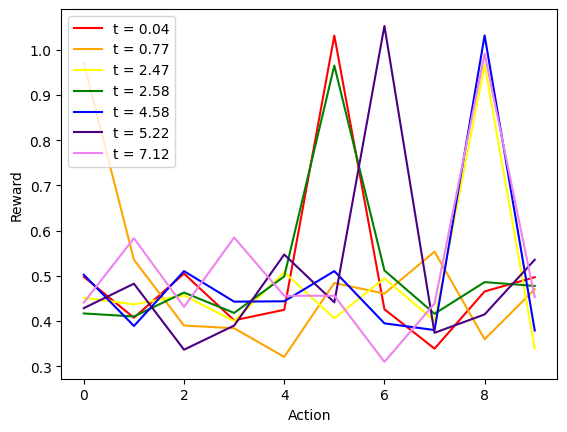

In [33]:
avg_reward = np.average(np.asarray(learned_rewards),axis = 0)
print(observation_times)
colors = ["red", "orange","yellow","green","blue","indigo","violet"]
for t in range(7):
    label = "t = " + format(round(observation_times[t],2))
    plt.plot(avg_reward[0,:,t], color=colors[t], label = label)
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.show()

[ 1.41478631  3.20021872  5.16931618  5.18805836  6.80733616  7.62271778
  8.61339695  9.44695707 10.6322433  10.8872403  12.57796339 13.48356203
 15.37683019 16.77379972 18.1205226  18.31340954 19.27233508 19.76316405
 21.12967853 22.34256651]


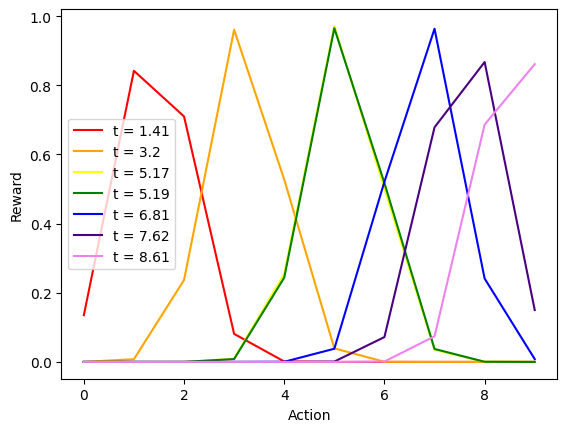

In [21]:
avg_reward = np.average(np.asarray(learned_rewards),axis = 0)
print(observation_times)
colors = ["red", "orange","yellow","green","blue","indigo","violet"]
for t in range(7):
    label = "t = " + format(round(observation_times[t],2))
    plt.plot(R[0,:,t], color=colors[t], label = label)

plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.show()

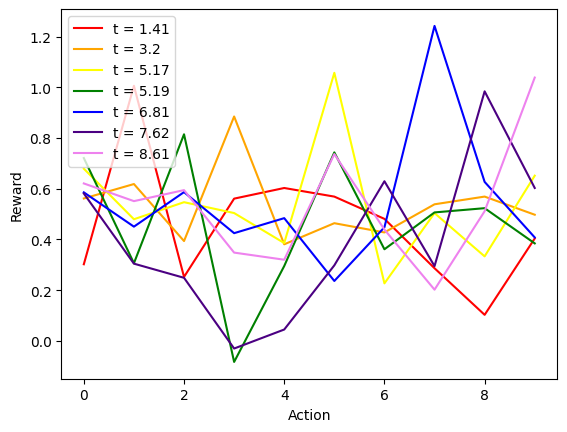

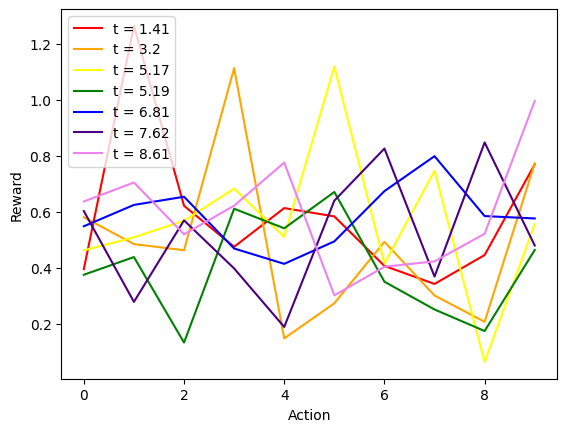

In [27]:
rewards = np.asarray(learned_rewards) 
rewards.shape
first_hundred = np.average(rewards[0:25], axis = 0) 
second_hundred = np.average(rewards[175:200], axis = 0) 

colors = ["red", "orange","yellow","green","blue","indigo","violet"]
for t in range(7):
    label = "t = " + format(round(observation_times[t],2))
    plt.plot(first_hundred[0,:,t], color=colors[t], label = label)

plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.show()


colors = ["red", "orange","yellow","green","blue","indigo","violet"]
for t in range(7):
    label = "t = " + format(round(observation_times[t],2))
    plt.plot(second_hundred[0,:,t], color=colors[t], label = label)

plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.show()

In [28]:
print(observations)

[[0, 1, 0], [0, 3, 1], [0, 5, 2], [0, 5, 3], [0, 7, 4], [0, 8, 5], [0, 9, 6], [0, 9, 7], [0, 9, 8], [0, 9, 9], [0, 8, 10], [0, 7, 11], [0, 5, 12], [0, 3, 13], [0, 2, 14], [0, 1, 15], [0, 1, 16], [0, 0, 17], [0, 0, 18], [0, 2, 19]]


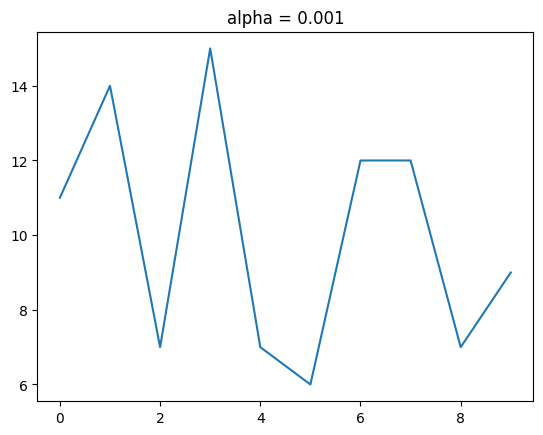

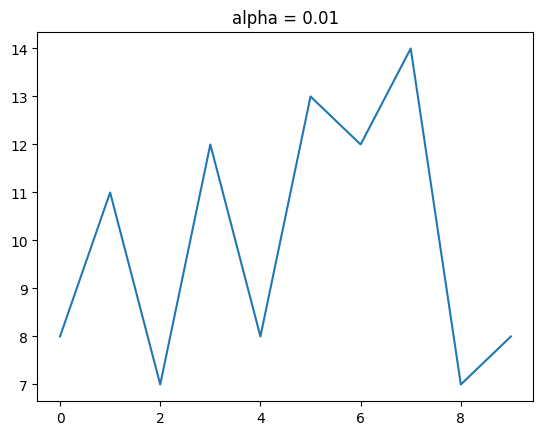

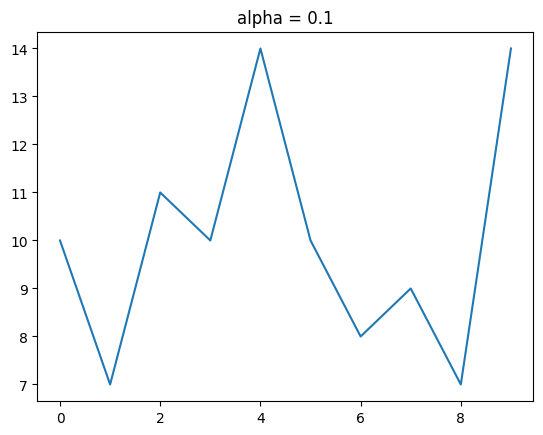

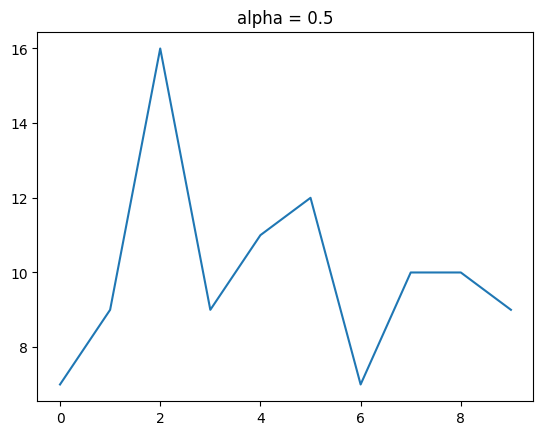

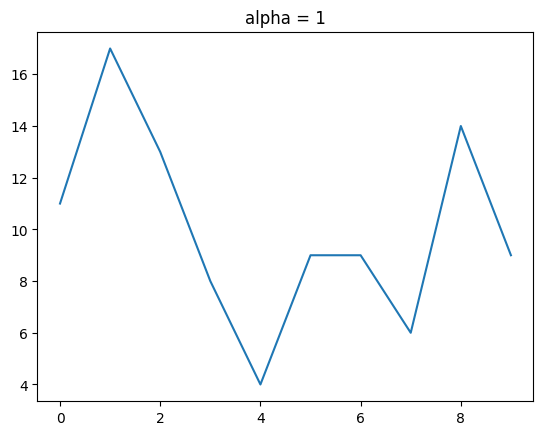

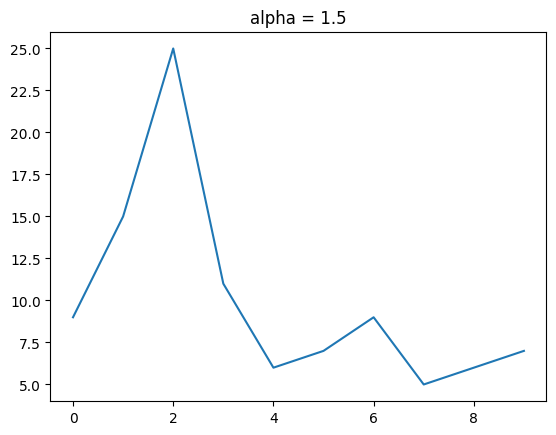

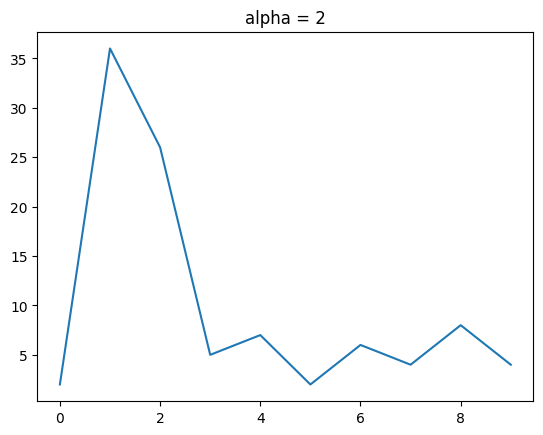

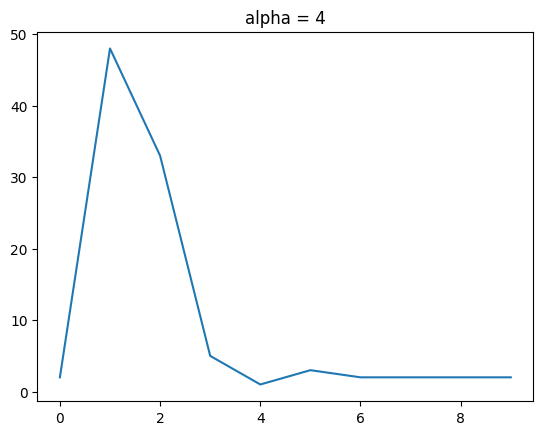

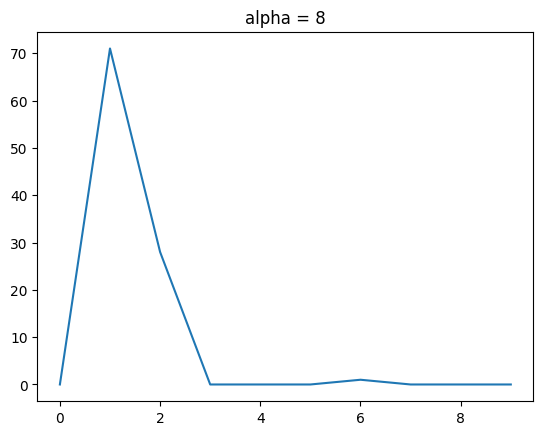

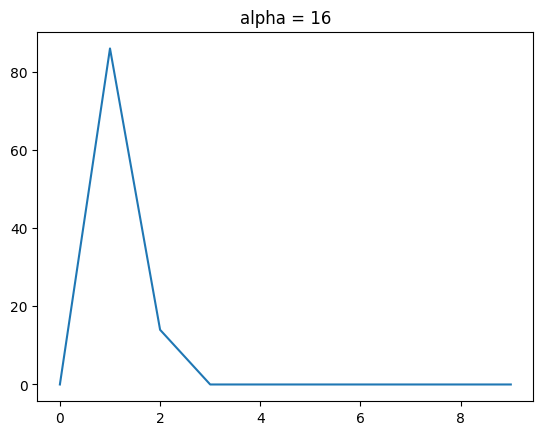

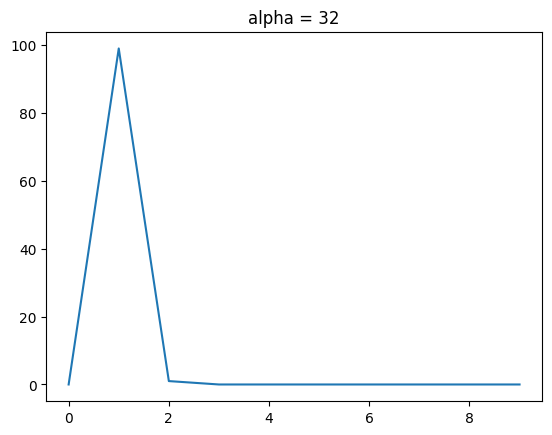

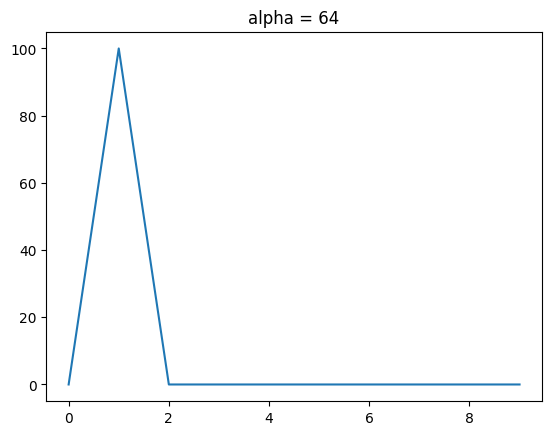

In [29]:

b = Boltzmann(optimal_q_values, env.actions)

#What is my initial policy? Everywhere I've seen, boltzmann is defined using the Q-values but you
#need a policy to find the Q-values so what is the actual policy? 
#Is it just like an exponential style distribution over the rewards? 
# observations = generate_trajectory(env, boltzmann_policy, observation_times)

alphas = [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2, 4, 8, 16, 32, 64]
for alpha in alphas: 
    b = Boltzmann(optimal_q_values,env.actions,alpha) 
    
    count = np.zeros(env.n_actions)
    for i in range(100): 
        count[b(0,0)] += 1
    plt.plot(count) 
    asd = "alpha = " + format(alpha)
    plt.title(asd)
    plt.show()